In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sodapy import Socrata

import sys
sys.path.append("..")

import src.config as config

In [2]:
sns.set(style="white", font_scale=2.5)

In [3]:
client = Socrata("data.sfgov.org",
                 config.api_key,
                 username=config.username,
                 password=config.password)

In [4]:
# This cell was ran once and the data was saved into a csv
# results_ml = client.get("wg3w-h783", limit=500000, order="incident_date DESC")
# df = pd.sDataFrame.from_records(results_ml)
# df.to_csv("sfpd_reports.csv", index=False)

In [5]:
# results_ml = client.get("tmnf-yvry", limit=2161000)
# df = pd.DataFrame.from_records(results_ml)
# df.to_csv("sfpd_reports_2013_2018.csv", index=False)

In [6]:
df = pd.read_csv("sfpd_reports.csv")
df2 = pd.read_csv("sfpd_reports_2013_2018.csv")

In [7]:
df2_new_columns = []

for i in df2.columns:
    if i.startswith(":"):
        continue
    else:
        df2_new_columns.append(i)

In [8]:
df2 = df2[df2_new_columns]

In [9]:
df2 = df2.rename(columns={"category":"incident_category", "dayofweek":"incident_day_of_week", "date":"incident_datetime",
                          "time":"incident_time", "pddistrict":"police_district", "x":"latitude", "y":"longitude"})

First we make remove any rows with missing data:

In [10]:
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'])
df = df[~df['incident_category'].isnull()]
df = df[~df['latitude'].isnull()]
df = df[~df['police_district'].isnull()]
df = df[["incident_datetime", "incident_day_of_week", "police_district", "incident_category"]]

In [11]:
df2['incident_datetime'] = pd.to_datetime(df2['incident_datetime'])
df2 = df2[~df2['incident_category'].isnull()]
df2 = df2[~df2['latitude'].isnull()]
df2 = df2[~df2['police_district'].isnull()]
df2 = df2[["incident_datetime", "incident_day_of_week", "police_district", "incident_category"]]

In [12]:
df2.police_district = df2.police_district.apply(lambda x: x.lower().capitalize())
df2.incident_category = df2.incident_category.apply(lambda x: x.lower().capitalize())

We want to predict the daily crime rate so we group the response by date. In other words, we resample the dataframe into one day bins.

In [13]:
group_by_pd = df.copy()
group_by_pd["Count"] = 1
group_by_pd = group_by_pd.set_index(group_by_pd["incident_datetime"]).drop(columns=["incident_datetime"])
group_by_pd = group_by_pd.groupby(['police_district']).resample('1D').sum()
group_by_pd = group_by_pd.reset_index()

In [14]:
group_by_pd2 = df2.copy()
group_by_pd2["Count"] = 1
group_by_pd2 = group_by_pd2.set_index(group_by_pd2["incident_datetime"]).drop(columns=["incident_datetime"])
group_by_pd2 = group_by_pd2.groupby(['police_district']).resample('1D').sum()
group_by_pd2 = group_by_pd2.reset_index()

In [15]:
group_by_pd.append(group_by_pd2)

,police_district,incident_datetime,Count
0,Bayview,2018-01-01,51
1,Bayview,2018-01-02,42
2,Bayview,2018-01-03,30
3,Bayview,2018-01-04,36
4,Bayview,2018-01-05,39
...,...,...,...
56127,Tenderloin,2018-05-10,17
56128,Tenderloin,2018-05-11,18
56129,Tenderloin,2018-05-12,13
56130,Tenderloin,2018-05-13,9


In [16]:
X = group_by_pd.append(group_by_pd2)

## Feature Engineering

Here, we one-hot encode the police district feature and create a feature for both the day and month:

In [17]:
X = pd.concat([X, pd.get_dummies(X["police_district"])], axis=1).drop(columns=["police_district"])

In [18]:
X['year'] = pd.to_datetime(X['incident_datetime']).dt.year

X['month'] = pd.to_datetime(X['incident_datetime']).dt.month
X['day'] = pd.to_datetime(X['incident_datetime']).dt.day

Given that the latest incidents will be approved later in the future we cannot use the last days as training data.

In [19]:
X = X.iloc[:-10]

In [20]:
y = X[["Count"]]
X = X.drop(['incident_datetime', "Count"], axis=1)

In [21]:
X.shape

(68382, 14)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

In [24]:
X_train

,Bayview,Central,Ingleside,Mission,Northern,Out of SF,Park,Richmond,Southern,Taraval,Tenderloin,year,month,day
51420,0,0,0,0,0,0,0,0,0,0,1,2005,6,20
27924,0,0,0,0,1,0,0,0,0,0,0,2017,12,25
9323,0,0,0,0,0,0,0,0,1,0,0,2019,2,13
20746,0,0,0,1,0,0,0,0,0,0,0,2013,9,13
44573,0,0,0,0,0,0,0,0,1,0,0,2017,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24934,0,0,0,0,1,0,0,0,0,0,0,2009,10,18
6265,0,0,0,0,0,1,0,0,0,0,0,2019,11,22
42626,0,0,0,0,0,0,0,0,1,0,0,2012,2,17
860,1,0,0,0,0,0,0,0,0,0,0,2020,5,10


## Training a DT Regressor

Here we use the scikit-learn implementation to train a DT model.

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [26]:
scoring = {'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error'}

In [27]:
dtr = DecisionTreeRegressor()


# Parameters of pipelines can be set using ‘__’ separated parameter names:
parameters_dt = {
    'max_depth':np.linspace(1, 20, 20).astype(int), 
    'min_samples_split':[2, 3, 4]
}


search_dt = GridSearchCV(dtr, parameters_dt, scoring=scoring, refit='MAE', n_jobs=-1, cv=None, return_train_score=True)
search_dt.fit(X_train, y_train)
# search_dt.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_dt.best_score_)
print(search_dt.best_params_)

Best parameter (CV score=-7.324):
{'max_depth': 10, 'min_samples_split': 4}


In [28]:
DT_RESULTS = pd.DataFrame(search_dt.cv_results_)

In [29]:
mae_train = mean_absolute_error(y_train, search_dt.predict(X_train))
mae_test = mean_absolute_error(y_test, search_dt.predict(X_test))
print("Train MAE: {}".format(mae_train))
print("Test MAE: {}\n".format(mae_test))

Train MAE: 6.963678132638159
Test MAE: 7.296462490955421



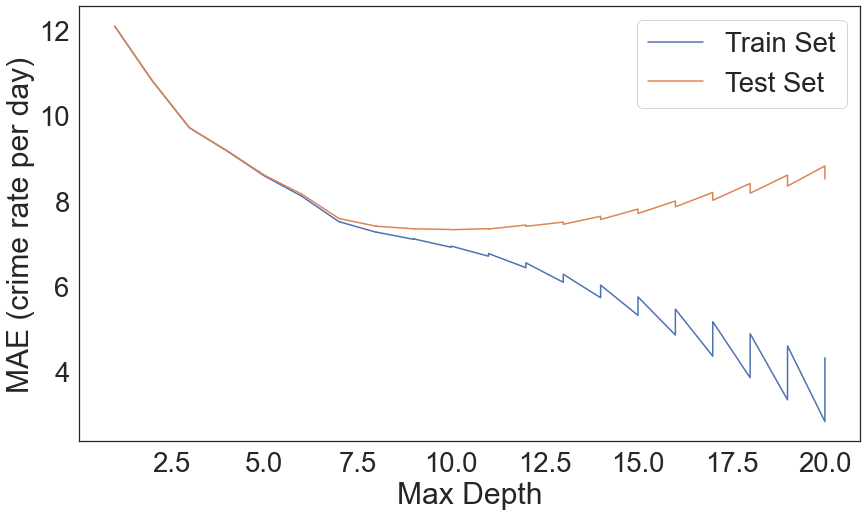

In [65]:
plt.figure(figsize=(14,8))
plt.plot(DT_RESULTS.param_max_depth.astype(int), -1*DT_RESULTS.mean_train_MAE, label="Train Set")
plt.plot(DT_RESULTS.param_max_depth.astype(int), -1*DT_RESULTS.mean_test_MAE, label="Test Set")
plt.xlabel("Max Depth")
plt.ylabel("MAE (crime rate per day)")
plt.legend()
plt.savefig("figures/dt_training.png", bbox_inches='tight', dpi=600)

## Train a SVM Model

In [30]:
from sklearn.svm import SVR

In [31]:
svr = SVR()
std = StandardScaler()

pipe_svr = Pipeline(steps=[('std', std), ('svm', svr)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
parameters_svr = {
    'svm__kernel':('poly', 'rbf'), 
    'svm__C':[100], 
    "svm__coef0":[3], 
    'svm__degree':[3]}


search_svr = GridSearchCV(pipe_svr, parameters_svr, scoring=scoring, refit='MAE', n_jobs=-1, cv=None, return_train_score=True)
search_svr.fit(X_train, y_train)
# search_svr.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_svr.best_score_)
print(search_svr.best_params_)

C:\Users\Pedro\Anaconda3\envs\tf_nightly\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Best parameter (CV score=-7.365):
{'svm__C': 100, 'svm__coef0': 3, 'svm__degree': 3, 'svm__kernel': 'rbf'}


In [32]:
mae_train = mean_absolute_error(y_train, search_svr.predict(X_train))
mae_test = mean_absolute_error(y_test, search_svr.predict(X_test))
print("Train MAE: {}".format(mae_train))
print("Test MAE: {}\n".format(mae_test))

Train MAE: 7.281654190755648
Test MAE: 7.395574023418399



In [35]:
# svr = SVR()
# std = StandardScaler()

# pipe_svr_all = Pipeline(steps=[('std', std), ('svm', svr)])

# # Parameters of pipelines can be set using ‘__’ separated parameter names:
# parameters_svr_all = {
#     'svm__kernel':('poly', 'rbf'), 
#     'svm__C':[1, 50, 100], 
#     "svm__coef0":[2, 3, 4, 5], 
#     'svm__degree':[2, 3, 4]}


# search_svr_all = GridSearchCV(pipe_svr_all, parameters_svr_all, scoring=scoring, refit='MAE', n_jobs=-1, cv=None, return_train_score=True)
# search_svr_all.fit(X_train, y_train)
# # search_svr_all.fit(X, y)
# print("Best parameter (CV score=%0.3f):" % search_svr_all.best_score_)
# print(search_svr_all.best_params_)

In [34]:
# mae_train = mean_absolute_error(y_train, search_svr_all.predict(X_train))
# mae_test = mean_absolute_error(y_test, search_svr_all.predict(X_test))
# print("Train MAE: {}".format(mae_train))
# print("Test MAE: {}\n".format(mae_test))

In [37]:
# SVM_RESULTS = pd.DataFrame(search_svr_all.cv_results_)

## Training a KNN Model

In [38]:
from sklearn import neighbors

In [41]:
knn = neighbors.KNeighborsRegressor()
std = StandardScaler()

pipe_knn = Pipeline(steps=[('std', std), ('knn', knn)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
parameters_knn = {
    'knn__weights':('uniform', 'distance'), 
    'knn__n_neighbors':np.linspace(1, 20, 20).astype(int), 
    "knn__p":[1, 2]
}


search_knn = GridSearchCV(pipe_knn, parameters_knn, scoring=scoring, refit='MAE', n_jobs=-1, cv=None, return_train_score=True)
search_knn.fit(X_train, y_train)
# search_knn.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_knn.best_score_)
print(search_knn.best_params_)

Best parameter (CV score=-7.212):
{'knn__n_neighbors': 20, 'knn__p': 1, 'knn__weights': 'distance'}


In [42]:
mae_train = mean_absolute_error(y_train, search_knn.predict(X_train))
mae_test = mean_absolute_error(y_test, search_knn.predict(X_test))
print("Train MAE: {}".format(mae_train))
print("Test MAE: {}\n".format(mae_test))

Train MAE: 0.1267888106628784
Test MAE: 7.194421355832896



In [64]:
KNN_RESULTS = pd.DataFrame(search_knn.cv_results_)

In [209]:
# MAX_DEPTH = []
# TRAIN_MAE = []
# TEST_MAE = []
# MSS = []

# for i in np.linspace(1, 20, 20).astype(int):
#     for mss in [2, 3, 4]:
#         regr_1 = DecisionTreeRegressor(max_depth=i, min_samples_split=mss)
#         regr_1.fit(X_train, y_train)
#         mae_train = mean_absolute_error(y_train, regr_1.predict(X_train))
#         mae_test = mean_absolute_error(y_test, regr_1.predict(X_test))
#         MAX_DEPTH.append(i)
#         MSS.append(mss)
#         TRAIN_MAE.append(mae_train)
#         TEST_MAE.append(mae_test)

# RESULTS_DF = pd.DataFrame({"MaxDepth":MAX_DEPTH, "MSS":MSS, "TrainMAE":TRAIN_MAE, "TestMAE":TEST_MAE})

# RESULTS_DF.sort_values(by="TrainMAE").head()

# RESULTS_DF.sort_values(by="TestMAE").head()

# svr_rbf = SVR(kernel='rbf', C=100, gamma='auto')
# svr_rbf_pipeline = make_pipeline(StandardScaler(), svr_rbf)

# svr_rbf_pipeline.fit(X_train, y_train)

# mae_train = mean_absolute_error(y_train, svr_rbf_pipeline.predict(X_train))
# mae_test = mean_absolute_error(y_test, svr_rbf_pipeline.predict(X_test))
# print("Train MAE: {}".format(mae_train))
# print("Test MAE: {}\n".format(mae_test))

# svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, coef0=3)
# svr_poly_pipeline = make_pipeline(StandardScaler(), svr_poly)

# svr_poly_pipeline.fit(X_train, y_train)

# mae_train = mean_absolute_error(y_train, svr_poly_pipeline.predict(X_train))
# mae_test = mean_absolute_error(y_test, svr_poly_pipeline.predict(X_test))
# print("Train MAE: {}".format(mae_train))
# print("Test MAE: {}\n".format(mae_test))

# knn = neighbors.KNeighborsRegressor()
# std = StandardScaler()

# pipe_knn_comp = Pipeline(steps=[('std', std), ('knn', knn)])

# # Parameters of pipelines can be set using ‘__’ separated parameter names:
# parameters_knn_comp = {
#     'knn__weights':('uniform', 'distance'), 
#     'knn__n_neighbors':np.linspace(1, 20, 20).astype(int), 
# }


# search_knn_comp = GridSearchCV(pipe_knn_comp, parameters_knn_comp, scoring=scoring, refit='MAE', n_jobs=-1, cv=None, return_train_score=True)
# search_knn_comp.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search_knn_comp.best_score_)
# print(search_knn_comp.best_params_)

# mae_train = mean_absolute_error(y_train, search_knn_comp.predict(X_train))
# mae_test = mean_absolute_error(y_test, search_knn_comp.predict(X_test))
# print("Train MAE: {}".format(mae_train))
# print("Test MAE: {}\n".format(mae_test))

# K_NUMBER = []
# WEIGHTS = []
# TRAIN_MAE_KNN = []
# TEST_MAE_KNN = []

# for weights in ["uniform", "distance"]:
#     for n_neighbors in range(1, 20):
#         knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
#         knn.fit(X_train, y_train)
        
#         mae_train = mean_absolute_error(y_train, knn.predict(X_train))
#         mae_test = mean_absolute_error(y_test, knn.predict(X_test))
#         K_NUMBER.append(n_neighbors)
#         WEIGHTS.append(weights)
#         TRAIN_MAE_KNN.append(mae_train)
#         TEST_MAE_KNN.append(mae_test)

# RESULTS_KNN = pd.DataFrame({"KNumber":K_NUMBER, "Weights":WEIGHTS, "TrainMAE":TRAIN_MAE_KNN, "TestMAE":TEST_MAE_KNN})

# RESULTS_KNN.sort_values(by="TrainMAE").head()

# RESULTS_KNN.sort_values(by="TestMAE").head()